In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Загружаем базу в формате csv
try:
    df = pd.read_csv("dt.csv", parse_dates = ['date'])
except FileNotFoundError:
    print("Ошибка: Файл не найден")
    df = None
except pd.errors.ParserError:
    print("Ошибка: Неверный формат CSV-файла")
    df = None

if df is not None:
    df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13244 entries, 0 to 13243
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 13244 non-null  datetime64[ns]
 1   client               13244 non-null  object        
 2   transportation_mode  13244 non-null  object        
 3   revenue_usd          13244 non-null  float64       
 4   cost_usd             13244 non-null  float64       
 5   profit_usd           13244 non-null  float64       
 6   margin_percent       13244 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 724.4+ KB


In [3]:
# Cмотрим на структуру таблицы
df.head()

,date,client,transportation_mode,revenue_usd,cost_usd,profit_usd,margin_percent
0,2022-01-04 15:37:47,Noble Associates,SEA,2320.36,2188.60,247.05,10.65
1,2022-01-17 22:42:02,Advanced Systems,SEA,9650.86,8643.69,431.47,4.47
2,2022-01-19 05:37:59,Alfa Resources,SEA,1026.93,727.15,175.58,17.10
3,2022-01-16 05:33:26,Eternal Alliance,SEA,6312.09,5698.86,387.15,6.13
4,2022-01-04 23:42:46,Core Dynamics,SEA,17951.05,16542.72,270.96,1.51


In [4]:
# Для удобства переименовываем колонки
df.rename(columns = {
    "date": "Month",
    "client": "Customer",
    "profit_usd": "Revenue"
}, inplace = True)

In [5]:
# Приводим дату к формату год-месяц, и находим последнюю дату для дальнейшего расчета
df['Month'] = pd.to_datetime(df['Month'], format = '%Y-%m')
max_date = df['Month'].max()
reference_date = max_date + pd.DateOffset(days = 1)

In [6]:
# Определяем дату последней покупки, сумму и количество заказов
rfm = df.groupby('Customer').agg({
    'Month': 'max',        
    'Revenue': ['count', 'sum'] 
})

In [7]:
# Переименовываем колонки и сбрасываем индексы
rfm.columns = ['LastPurchaseDate', 'Frequency', 'Monetary']
rfm.reset_index(inplace=True)

In [8]:
# Высчитываем количество дней от последнего заказа
rfm['Recency'] = (reference_date - rfm['LastPurchaseDate']).dt.days

In [9]:
# Определяем квартилями разделение для метрик RFM
r_quartiles = rfm['Recency'].quantile([0.2, 0.4, 0.6, 0.8]).values
f_quartiles = rfm['Frequency'].quantile([0.2, 0.4, 0.6, 0.8]).values
m_quartiles = rfm['Monetary'].quantile([0.2, 0.4, 0.6, 0.8]).values

In [10]:
def score_value(x: float, quartiles: list, is_recency: bool = False) -> int:
    """
    Универсальная функция для расчёта оценок Recency, Frequency и Monetary.

    Если `is_recency=True`, более низкие значения x получают более высокий балл (5 - лучше, 1 - хуже).
    В остальных случаях более высокие значения получают более высокий балл.

    Параметры:
        x (float): Значение для оценки.
        quartiles (list): Список квартильных порогов.
        is_recency (bool): Флаг для инверсии оценки (по умолчанию False).

    Возвращает:
        int: Оценка от 1 до 5.
    """
    if pd.isna(x):
        return np.nan
    
    for i, threshold in enumerate(quartiles):
        if x <= threshold:
            return (5 - i) if is_recency else (i + 1)
    
    return 1 if is_recency else 5

In [11]:
# Применяем фукнцию к DataFrame
rfm['R_Score'] = rfm['Recency'].apply(score_value, args=(r_quartiles, True))
rfm['F_Score'] = rfm['Frequency'].apply(score_value, args=(f_quartiles, False))
rfm['M_Score'] = rfm['Monetary'].apply(score_value, args=(m_quartiles, False))

In [12]:
# Перевеводим в строчный формат значения, пропуски заменяем на нули
rfm['RFM_Score'] = (
    rfm['R_Score'].map(str) +
    rfm['F_Score'].map(str) +
    rfm['M_Score'].map(str)
)

rfm.fillna(0, inplace = True)

In [13]:
rfm

,Customer,LastPurchaseDate,Frequency,Monetary,Recency,R_Score,F_Score,M_Score,RFM_Score
0,Active Alliance,2022-06-28 08:45:04,2,595.26,184,2,2,3,223
1,Active Associates,2022-12-28 20:59:16,3,887.88,1,5,3,3,533
2,Active Consulting,2022-12-19 17:32:42,17,2573.98,10,5,5,4,554
3,Active Dynamics,2022-10-21 02:49:10,9,1367.03,69,3,4,4,344
4,Active Edge,2022-10-04 16:46:03,10,1543.11,86,3,4,4,344
...,...,...,...,...,...,...,...,...,...
589,Visionary Systems,2022-10-28 05:11:41,9,4200.84,62,3,4,5,345
590,Visionary Tech,2022-01-17 08:48:06,2,1280.22,346,1,2,4,124
591,Visionary Technologies,2022-05-17 16:01:39,2,2034.46,226,1,2,4,124
592,Visionary Trust,2022-08-24 21:03:19,1,38.04,127,2,1,1,211


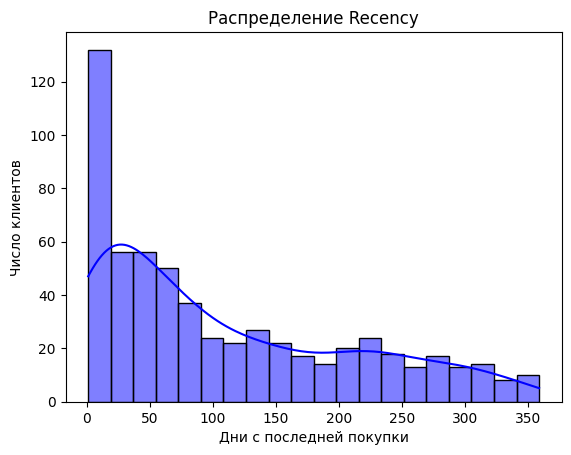

In [14]:
sns.histplot(rfm['Recency'], bins = 20, kde = True, color = 'blue')
plt.title('Распределение Recency')
plt.xlabel('Дни с последней покупки')
plt.ylabel('Число клиентов')
plt.show()

Большинство клиентов совершили покупку недавно (до 50 дней назад).

Длинный "хвост" справа говорит о том, что есть клиенты, которые давно не совершали покупки.

Это типичное распределение для бизнеса: есть активные клиенты и те, кто со временем перестаёт покупать.

Вывод: Стоит реактивировать неактивных клиентов с помощью маркетинговых кампаний (например, рассылки со скидками).

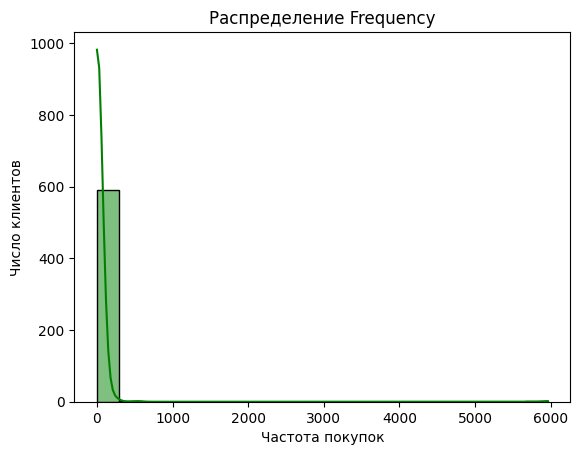

In [15]:
sns.histplot(rfm['Frequency'], bins = 20, kde = True, color = 'green')
plt.title('Распределение Frequency')
plt.xlabel('Частота покупок')
plt.ylabel('Число клиентов')
plt.show()

Подавляющее большинство клиентов совершает мало покупок (до 50 раз).

Есть несколько аномально активных клиентов (покупки в районе 5000 раз).

Это говорит о том, что бизнес имеет основную массу клиентов с низкой частотой покупок и немного VIP-клиентов с высокой активностью.

Вывод: Стоит создать отдельные предложения для частых покупателей (например, программы лояльности).

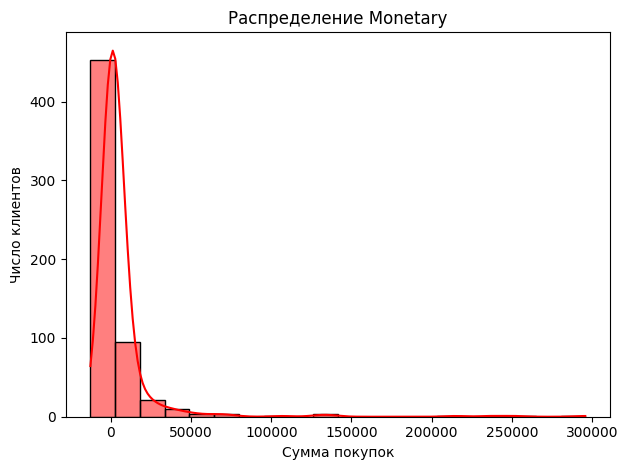

In [16]:
sns.histplot(rfm['Monetary'], bins = 20, kde = True, color = 'red')
plt.title('Распределение Monetary')
plt.xlabel('Сумма покупок')
plt.ylabel('Число клиентов')
plt.tight_layout()
plt.show()

Большинство клиентов тратит небольшие суммы (до 50 000).

Есть редкие клиенты с очень большими тратами (до 300 000).

Распределение сильно асимметрично: основная масса клиентов — это низкие чеки, но есть несколько очень ценных клиентов.

Вывод: Стоит удерживать VIP-клиентов, предлагая персонализированные скидки и сервис.

Программа действия:


✅ Реактивация клиентов, давно не делавших покупок.

✅ Программа лояльности для частых покупателей.

✅ Фокус на VIP-клиентах для увеличения их LTV.